# U-Net

- 참조
    - U-Net: Convolutional Network for Biomedical Image Segmentation

## 1. Basic Concept

### 1.1. CNN

<img src = "./image/cnn_architecture.png">

- CNN의 기본 구조
    - Convolutional Layer : 필터라는 작은 크기의 창으로 이미지를 슬라이딩하면서 특징을 추출
    - Pooling Layer : 중요한 정보를 유지한 상태로 이미지를 축소하는 역할
    - Fully Connected Layer : 이미지에서 추출한 특징을 이용해 분류 작업을 수행하는 역할
- 그러나 일반적으로 이러한 작업은 하나의 이미지에 대한 출력이 단일 클래스 레이블인 분류 작업
- 많은 이미지 작업에서 이미지 처리는, 원하는 출력에 Localization이 포함되어야 함

### 1.2. Classification / Localization / Object Detection / Segmentation

<img src = "./image/object_detection.png">

- Classification
    - 이미지가 어떤 클래스에 해당하는 지 분류
- Localization
    - 해당 객체가 어디 있는 지 예측
- Object Detection
    - 하나의 이미지 내에 여러 개의 객체가 존재할 때, 각각의 객체마다 그 위치를 설정하는 Localization을 수행하고 각각의 Bounding Box마다 어떤 클래스에 해당하는 지 분류
- Segmentation
    - 하나의 이미지 내에 여러 객체가 존재하는 상황에서 각각의 객체를 픽셀 단위로 예측
    
### 1.3. Fully Convolutional Neural Network (FCN)

<img src = "./image/fcn.png">

- U-Net은 FCN을 기반으로 발전된 딥러닝 아키텍쳐
- FCN은 입력 이미지를 받아 다양한 크기의 컨볼루션 필터를 사용하여 피처 맵을 추출
- 이후, 업샘플링을 거쳐 원본 이미지 크기와 같은 segmentation map을 생성
- FCN은 입력 이미지의 크기에 상관없이 출력을 생성할 수 있음

## 2. Network Architecture

<img src = "./image/unet_architecture.png">

- U-Net 아키텍처는 다음 그림과 같이 대칭 형태로 모델이 구성 됨
- 일반적인 분류 작업에서는 해상도가 계속 줄어들어 마지막에 클래스의 개수와 같은 차원을 갖게 되지만,
- segmentation에서는 입력 이미지와 같은 해상도를 가지는 출력 이미지가 나오게 됨
- U-Net 모델은 Contracting Path와 Expansive Path로 나뉨

### 2.1. Contracting Path (수축 경로)

- 이미지에 존재하는 넓은 context 정보를 처리함
- 일반적인 CNN 아키텍처를 따름
- 패딩 없이 컨볼루션 레이어 두 번을 통과시켜 채널의 수를 증가시키고 ReLU와 MaxPooling을 진행하는데, 이때 해상도가 절반으로 줄어들게 됨
- 이런 구조를 반복해서 채널의 수를 늘리고 해상도를 줄이는 작업 반복
    - 3x3 Convolutional Layer + ReLU + BatchNorm (No Padding, Stride 1)
    - 3x3 Convolutional Layer + ReLU + BatchNorm (No Padding, Stride 1)
    - 2x2 MaxPooling Layer (Stride 2)
    
### 2.2. Expansive Path (확장 경로)

- 확장 경로의 각 단계에서는 피처 맵을 업샘플링한 다음, 같은 레벨의 Contracting Path의 feature map을 크롭해서 병합 (패딩 없이 진행하기 때문에 가장자리에서 손실이 있기 때문에 크롭을 진행해서 사이즈 맞추는 작업)
- 그 뒤로 컨볼루션 레이어를 두 번 통과함
- 이 과정을 반복한 후, 마지막 레이어에서는 1x1 Convolutional Layer를 통과해 입력 이미지의 각 위치에서 해당 픽셀이 어떤 클래스에 속하는 지 확률값 계산
    - 2x2 Deconvolution Layer (Stride 2)
    - Contracting Path의 Feature map 추출 -> Crop -> Concat
    - 3x3 Convolutional Layer + ReLU + BatchNorm (No Padding, Stride 1)
    - 3x3 Convolutional Layer + ReLU + BatchNorm (No Padding, Stride 1)

## 3. Training

### 3.1. Overlap-tile Strategy

<img src = "./image/overlaptile.png">

- U-Net에서는 훈련 과정에서 Overlap-tile 전략이 사용 됨
- 그림에서 오른쪽 노란색 박스 영역을 분할하기 위해서 파란색 박스 영역의 이미지 데이터를 입력 데이터로 사용
- U-Net의 구조를 보면 출력 이미지의 해상도가 입력 이미지보다 작기 때문에 이처럼 더 큰 범위의 패치를 삽입
- 이때 인접한 타일들은 서로 겹치는 구간이 생기는데, 입력 이미지의 전체 영역을 효과적으로 커버할 수 있고 큰 이미지를 작은 크기의 타일로 분할해서 처리하기 때문에 메모리와 계산 시간을 줄일 수 있음
- 또한 중복 구간을 이용해서 처리 결과의 일관성과 정확성을 높일 수 있음

### 3.2. Mirroring Extrapolate

<img src = "./image/mirroring.png">

- 이미지 경계 외부의 픽셀을 대체하기 위한 기법
- 다음 그림처럼 이미지 경계 부근에 있는 픽셀에 대해 미러링을 사용해 이미지 경계의 픽셀을 채워주게 됨
- 이를 통해 모델이 경계 부근에서도 정확한 예측을 할 수 있도록 도움

### 3.3. Weight Loss

<img src = "./image/unet_pixel-wise_loss_weight.png">

- U-Net은 세포를 명확히 구분하기 위해 작은 분리 경계를 학습
- 함수 w를 사용하여 인접한 셀 사이에 있는 배경 레이블에 대해 높은 가중치를 부여해 명확한 분리를 수행
- 오른쪽 그림과 같이 경계 부분에서 가중치가 크게 나타남

### 3.4. Data Augmentation

<img src = "./image/Data-augmentation.png">

- 데이터 증강은 모델의 학습을 개선하기 위해 입력 이미지를 다양한 방식으로 변형시키는 기술
- Biomedical Image의 경우에는 많은 양의 데이터를 확보하는 데 제한사항이 있기 때문에 데이터 증강을 통해 모델을 강건하도록 학습시킴

<img src = "./image/elastic_deformation.png">

- U-Net은 추가적으로 Elastic Deformation이라는 기법으로 데이터를 증강함
- 이미지에 무작위한 강도의 노이즈를 추가하는 것과 달리 좀 더 자연스러운 형태의 변형을 적용
- 이를 통해 이미지를 축소시킨 다음 원래 크기로 다시 확대시키는 과정에서 발생하는 정보의 손실을 방지하고 모델이 더욱 일반화된 학습을 수행하도록 도움

## 4. 예제 구현

### 데이터셋

- ISBI 2012 EM Segmentation Challenge에 사용된 membrane 데이터셋
- dataset
    - train-volumne.tif : 훈련 이미지
    - train-labels.tif : 훈련 이미지의 분할 레이블
    - test-volumne.tif : 테스트 이미지

### 데이터셋 전처리

- .tif 파일에는 512x512 크기의 이미지 30개 압축
- 이를 한 이미지씩 .npy 파일로 풀어주는 작업
- 학습, 훈련, 검증 데이터를 각각 24, 3, 3개씩 분류해서 train, test, val 폴더에 저장

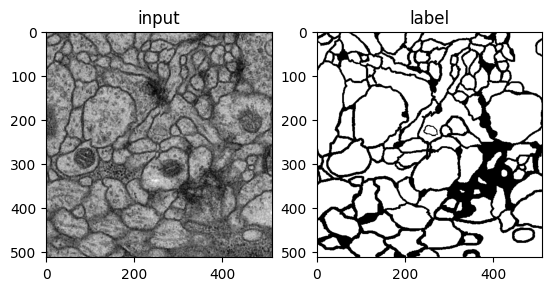

In [4]:
## 라이브러리 불러오기
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

## 데이터 불러오기
dir_data = './data' 

name_label = 'train-labels.tif'
name_input = 'train-volume.tif'

img_label = Image.open(os.path.join(dir_data, name_label))
img_input = Image.open(os.path.join(dir_data, name_input))

ny, nx = img_label.size
nframe = img_label.n_frames

## train/test/val 폴더 생성
nframe_train = 24
nframe_val = 3
nframe_test = 3

dir_save_train = os.path.join(dir_data, 'train')
dir_save_val = os.path.join(dir_data, 'val')
dir_save_test = os.path.join(dir_data, 'test')

if not os.path.exists(dir_save_train):
    os.makedirs(dir_save_train)

if not os.path.exists(dir_save_val):
    os.makedirs(dir_save_val)

if not os.path.exists(dir_save_test):
    os.makedirs(dir_save_test)

## 전체 이미지 30개를 섞어줌
id_frame = np.arange(nframe)
np.random.shuffle(id_frame)

## 선택된 train 이미지를 npy 파일로 저장
offset_nframe = 0

for i in range(nframe_train):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(dir_save_train, 'label_%03d.npy' % i), label_)
    np.save(os.path.join(dir_save_train, 'input_%03d.npy' % i), input_)

## 선택된 val 이미지를 npy 파일로 저장
offset_nframe = nframe_train

for i in range(nframe_val):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(dir_save_val, 'label_%03d.npy' % i), label_)
    np.save(os.path.join(dir_save_val, 'input_%03d.npy' % i), input_)

## 선택된 test 이미지를 npy 파일로 저장
offset_nframe = nframe_train + nframe_val

for i in range(nframe_test):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(dir_save_test, 'label_%03d.npy' % i), label_)
    np.save(os.path.join(dir_save_test, 'input_%03d.npy' % i), input_)

## 이미지 시각화
plt.subplot(122)
plt.imshow(label_, cmap='gray')
plt.title('label')

plt.subplot(121)
plt.imshow(input_, cmap='gray')
plt.title('input')

plt.show()

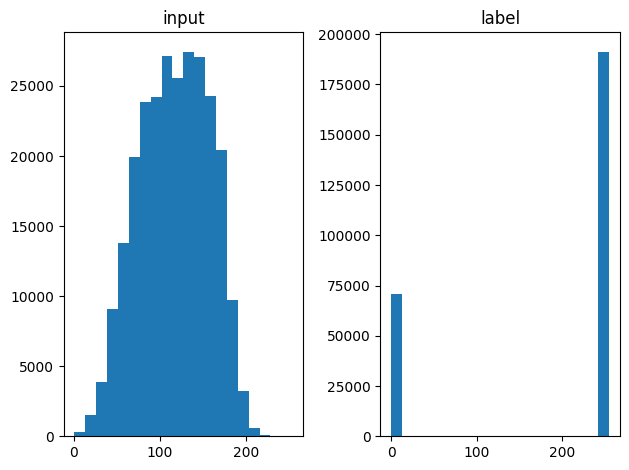

In [5]:
## 한 이미지의 분포
plt.subplot(122)
plt.hist(label_.flatten(), bins=20)
plt.title('label')

plt.subplot(121)
plt.hist(input_.flatten(), bins=20)
plt.title('input')

plt.tight_layout()
plt.show()

### U-Net 구축

- Conv 3x3 + Batch Normalizatin + Relu 를 CBR2d라는 함수로 정의하고 이를 forward 에서 반복해서 사용

In [6]:
## 라이브러리 불러오기
import os
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

from torchvision import transforms, datasets

## 네트워크 구축하기
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Convolution + BatchNormalization + Relu 정의하기
        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True): 
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr

        # 수축 경로(Contracting path)
        self.enc1_1 = CBR2d(in_channels=1, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)

        # 확장 경로(Expansive path)
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)
    
    # forward 함수 정의하기
    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)

        return x

### DataLoader 및 Transform 정의

### DataLoader

- 네트워크에 데이터를 올리기 위함

In [7]:
# 데이터 로더를 구현하기
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        lst_data = os.listdir(self.data_dir)

        lst_label = [f for f in lst_data if f.startswith('label')]
        lst_input = [f for f in lst_data if f.startswith('input')]

        lst_label.sort()
        lst_input.sort()

        self.lst_label = lst_label
        self.lst_input = lst_input

    def __len__(self):
        return len(self.lst_label)

    def __getitem__(self, index):
        label = np.load(os.path.join(self.data_dir, self.lst_label[index]))
        input = np.load(os.path.join(self.data_dir, self.lst_input[index]))

        # 정규화
        label = label/255.0
        input = input/255.0

        # 이미지와 레이블의 차원 = 2일 경우(채널이 없을 경우, 흑백 이미지), 새로운 채널(축) 생성
        if label.ndim == 2:
            label = label[:, :, np.newaxis]
        if input.ndim == 2:
            input = input[:, :, np.newaxis]

        data = {'input': input, 'label': label}

        # transform이 정의되어 있다면 transform을 거친 데이터를 불러옴
        if self.transform:
            data = self.transform(data)

        return data

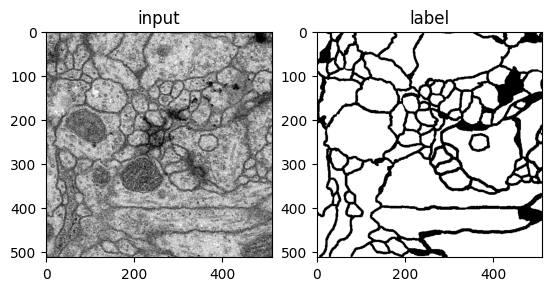

In [8]:
# 데이터로더 잘 구현되었는지 확인
dataset_train = Dataset(data_dir=dir_save_train)
data = dataset_train.__getitem__(0) # 한 이미지 불러오기
input = data['input']
label = data['label']

# 불러온 이미지 시각화
plt.subplot(122)
plt.imshow(label.reshape(512,512), cmap='gray')
plt.title('label')

plt.subplot(121)
plt.imshow(input.reshape(512,512), cmap='gray')
plt.title('input')

plt.show()

### Transform

- ToTensor : numpy에서 tensor로 dtype을 변경
- Normalization : 데이터 정규화
- RandomFlip : 랜덤 좌우 및 상하 반전

In [9]:
# 트렌스폼 구현하기
class ToTensor(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        label = label.transpose((2, 0, 1)).astype(np.float32)
        input = input.transpose((2, 0, 1)).astype(np.float32)

        data = {'label': torch.from_numpy(label), 'input': torch.from_numpy(input)}

        return data

class Normalization(object):
    def __init__(self, mean=0.5, std=0.5):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        label, input = data['label'], data['input']

        input = (input - self.mean) / self.std

        data = {'label': label, 'input': input}

        return data

class RandomFlip(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        if np.random.rand() > 0.5:
            label = np.fliplr(label)
            input = np.fliplr(input)

        if np.random.rand() > 0.5:
            label = np.flipud(label)
            input = np.flipud(input)

        data = {'label': label, 'input': input}

        return data

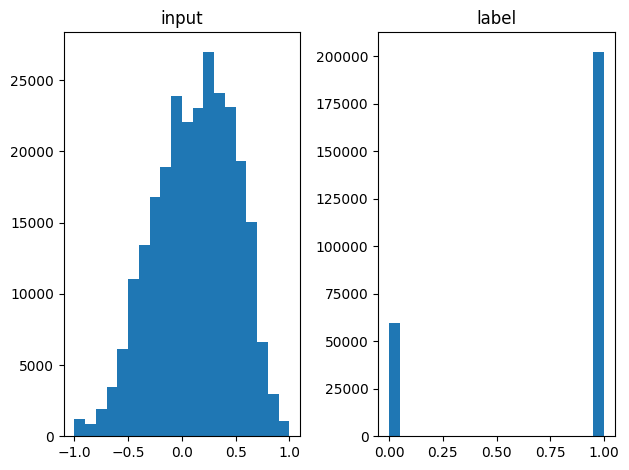

In [10]:
# 트랜스폼 잘 구현되었는지 확인
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), RandomFlip(), ToTensor()])
dataset_train = Dataset(data_dir=dir_save_train, transform=transform)
data = dataset_train.__getitem__(0) # 한 이미지 불러오기
input = data['input']
label = data['label']

# 불러온 이미지 시각화
plt.subplot(122)
plt.hist(label.flatten(), bins=20)
plt.title('label')

plt.subplot(121)
plt.hist(input.flatten(), bins=20)
plt.title('input')

plt.tight_layout()
plt.show()

### 네트워크 저장/불러오기 함수 정의

In [11]:
## 네트워크 저장하기
def save(ckpt_dir, net, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'net': net.state_dict(), 'optim': optim.state_dict()},
               "%s/model_epoch%d.pth" % (ckpt_dir, epoch))

## 네트워크 불러오기
def load(ckpt_dir, net, optim):
    if not os.path.exists(ckpt_dir):
        epoch = 0
        return net, optim, epoch

    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

    dict_model = torch.load('%s/%s' % (ckpt_dir, ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])
    epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pth')[0])

    return net, optim, epoch

### 네트워크 훈련

In [15]:
# 훈련 파라미터 설정하기
lr = 1e-3
batch_size = 4
num_epoch = 20

base_dir = './data/unet'
data_dir = dir_data
ckpt_dir = os.path.join(base_dir, "checkpoint")
log_dir = os.path.join(base_dir, "log")


# 훈련을 위한 Transform과 DataLoader
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), RandomFlip(), ToTensor()])

dataset_train = Dataset(data_dir=os.path.join(data_dir, 'train'), transform=transform)
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)

dataset_val = Dataset(data_dir=os.path.join(data_dir, 'val'), transform=transform)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=0)

# 네트워크 생성하기
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = UNet().to(device)

# 손실함수 정의하기
fn_loss = nn.BCEWithLogitsLoss().to(device)

# Optimizer 설정하기
optim = torch.optim.Adam(net.parameters(), lr=lr)

# 그밖에 부수적인 variables 설정하기
num_data_train = len(dataset_train)
num_data_val = len(dataset_val)

num_batch_train = np.ceil(num_data_train / batch_size)
num_batch_val = np.ceil(num_data_val / batch_size)

# 그 밖에 부수적인 functions 설정하기
fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
fn_denorm = lambda x, mean, std: (x * std) + mean
fn_class = lambda x: 1.0 * (x > 0.5)

# Tensorboard 를 사용하기 위한 SummaryWriter 설정
writer_train = SummaryWriter(log_dir=os.path.join(log_dir, 'train'))
writer_val = SummaryWriter(log_dir=os.path.join(log_dir, 'val'))

# 네트워크 학습시키기
st_epoch = 0
# 학습한 모델이 있을 경우 모델 로드하기
net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim) 

for epoch in range(st_epoch + 1, num_epoch + 1):
        net.train()
        loss_arr = []

        for batch, data in enumerate(loader_train, 1):
            # forward pass
            label = data['label'].to(device)
            input = data['input'].to(device)

            output = net(input)

            # backward pass
            optim.zero_grad()

            loss = fn_loss(output, label)
            loss.backward()

            optim.step()

            # 손실함수 계산
            loss_arr += [loss.item()]

            print("TRAIN: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f" %
                  (epoch, num_epoch, batch, num_batch_train, np.mean(loss_arr)))

            # Tensorboard 저장하기
            label = fn_tonumpy(label)
            input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
            output = fn_tonumpy(fn_class(output))

            writer_train.add_image('label', label, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')
            writer_train.add_image('input', input, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')
            writer_train.add_image('output', output, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')

        writer_train.add_scalar('loss', np.mean(loss_arr), epoch)

        with torch.no_grad():
            net.eval()
            loss_arr = []

            for batch, data in enumerate(loader_val, 1):
                # forward pass
                label = data['label'].to(device)
                input = data['input'].to(device)

                output = net(input)

                # 손실함수 계산하기
                loss = fn_loss(output, label)

                loss_arr += [loss.item()]

                print("VALID: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f" %
                      (epoch, num_epoch, batch, num_batch_val, np.mean(loss_arr)))

                # Tensorboard 저장하기
                label = fn_tonumpy(label)
                input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
                output = fn_tonumpy(fn_class(output))

                writer_val.add_image('label', label, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')
                writer_val.add_image('input', input, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')
                writer_val.add_image('output', output, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')

        writer_val.add_scalar('loss', np.mean(loss_arr), epoch)

        # epoch 50마다 모델 저장하기
        if epoch % 50 == 0:
            save(ckpt_dir=ckpt_dir, net=net, optim=optim, epoch=epoch)

        writer_train.close()
        writer_val.close()

TRAIN: EPOCH 0001 / 0020 | BATCH 0001 / 0006 | LOSS 0.6463
TRAIN: EPOCH 0001 / 0020 | BATCH 0002 / 0006 | LOSS 0.5892
TRAIN: EPOCH 0001 / 0020 | BATCH 0003 / 0006 | LOSS 0.5588
TRAIN: EPOCH 0001 / 0020 | BATCH 0004 / 0006 | LOSS 0.5361
TRAIN: EPOCH 0001 / 0020 | BATCH 0005 / 0006 | LOSS 0.5151
TRAIN: EPOCH 0001 / 0020 | BATCH 0006 / 0006 | LOSS 0.4988
VALID: EPOCH 0001 / 0020 | BATCH 0001 / 0001 | LOSS 0.6023
TRAIN: EPOCH 0002 / 0020 | BATCH 0001 / 0006 | LOSS 0.4148
TRAIN: EPOCH 0002 / 0020 | BATCH 0002 / 0006 | LOSS 0.4034
TRAIN: EPOCH 0002 / 0020 | BATCH 0003 / 0006 | LOSS 0.3912
TRAIN: EPOCH 0002 / 0020 | BATCH 0004 / 0006 | LOSS 0.3827
TRAIN: EPOCH 0002 / 0020 | BATCH 0005 / 0006 | LOSS 0.3760
TRAIN: EPOCH 0002 / 0020 | BATCH 0006 / 0006 | LOSS 0.3703
VALID: EPOCH 0002 / 0020 | BATCH 0001 / 0001 | LOSS 0.4954
TRAIN: EPOCH 0003 / 0020 | BATCH 0001 / 0006 | LOSS 0.3345
TRAIN: EPOCH 0003 / 0020 | BATCH 0002 / 0006 | LOSS 0.3334
TRAIN: EPOCH 0003 / 0020 | BATCH 0003 / 0006 | LOSS 0.32

VALID: EPOCH 0020 / 0020 | BATCH 0001 / 0001 | LOSS 0.1825


### 훈련된 모델 테스트

In [16]:
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), ToTensor()])

dataset_test = Dataset(data_dir=os.path.join(data_dir, 'test'), transform=transform)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=0)

# 그밖에 부수적인 variables 설정하기
num_data_test = len(dataset_test)
num_batch_test = np.ceil(num_data_test / batch_size)

# 결과 디렉토리 생성하기
result_dir = os.path.join(base_dir, 'result')
if not os.path.exists(result_dir):
    os.makedirs(os.path.join(result_dir, 'png'))
    os.makedirs(os.path.join(result_dir, 'numpy'))


net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim)

with torch.no_grad():
        net.eval()
        loss_arr = []

        for batch, data in enumerate(loader_test, 1):
          # forward pass
            label = data['label'].to(device)
            input = data['input'].to(device)

            output = net(input)

            # 손실함수 계산하기
            loss = fn_loss(output, label)

            loss_arr += [loss.item()]

            print("TEST: BATCH %04d / %04d | LOSS %.4f" % 
                  (batch, num_batch_test, np.mean(loss_arr)))

          # Tensorboard 저장하기
            label = fn_tonumpy(label)
            input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
            output = fn_tonumpy(fn_class(output))

          # 테스트 결과 저장하기
            for j in range(label.shape[0]):
                id = num_batch_test * (batch - 1) + j

                plt.imsave(os.path.join(result_dir, 'png', 'label_%04d.png' % id), label[j].squeeze(), cmap='gray')
                plt.imsave(os.path.join(result_dir, 'png', 'input_%04d.png' % id), input[j].squeeze(), cmap='gray')
                plt.imsave(os.path.join(result_dir, 'png', 'output_%04d.png' % id), output[j].squeeze(), cmap='gray')

                np.save(os.path.join(result_dir, 'numpy', 'label_%04d.npy' % id), label[j].squeeze())
                np.save(os.path.join(result_dir, 'numpy', 'input_%04d.npy' % id), input[j].squeeze())
                np.save(os.path.join(result_dir, 'numpy', 'output_%04d.npy' % id), output[j].squeeze())

print("AVERAGE TEST: BATCH %04d / %04d | LOSS %.4f" %
        (batch, num_batch_test, np.mean(loss_arr)))

TEST: BATCH 0001 / 0001 | LOSS 0.2371
AVERAGE TEST: BATCH 0001 / 0001 | LOSS 0.2371


### 시각화

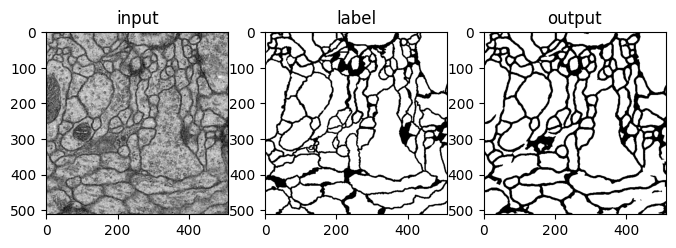

In [17]:
##
lst_data = os.listdir(os.path.join(result_dir, 'numpy'))

lst_label = [f for f in lst_data if f.startswith('label')]
lst_input = [f for f in lst_data if f.startswith('input')]
lst_output = [f for f in lst_data if f.startswith('output')]

lst_label.sort()
lst_input.sort()
lst_output.sort()

##
id = 0

label = np.load(os.path.join(result_dir,"numpy", lst_label[id]))
input = np.load(os.path.join(result_dir,"numpy", lst_input[id]))
output = np.load(os.path.join(result_dir,"numpy", lst_output[id]))

## 플롯 그리기
plt.figure(figsize=(8,6))
plt.subplot(131)
plt.imshow(input, cmap='gray')
plt.title('input')

plt.subplot(132)
plt.imshow(label, cmap='gray')
plt.title('label')

plt.subplot(133)
plt.imshow(output, cmap='gray')
plt.title('output')

plt.show()